In [65]:
import dolphindb as ddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def draw(ic: pd.DataFrame):
    _, axs = plt.subplots(4, figsize=(5, 10))
    p_cols = [col for col in ic.columns if col.startswith('p')]
    s_cols = [col for col in ic.columns if col.startswith('s')]
    ic[p_cols].mean().plot(legend=True, ax=axs[0], kind='bar')
    ic.set_index("trade_time")['pic'].cumsum().plot(legend=True, ax=axs[1])
    ic[s_cols].mean().plot(legend=True, ax=axs[2], kind='bar')
    ic.set_index("trade_time")['sic'].cumsum().plot(legend=True, ax=axs[3])

def draw_rev(rev: pd.DataFrame):
    rev.set_index(['trade_time', 'grp']).groupby(level=1)['af_rev'].plot(legend=True)
    plt.legend(loc='lower right')

def cal_t(ic: pd.Series):
    corr = ic.corr(ic.shift(1))
    clean_ic = (ic - corr * ic.shift(1)).dropna()
    return clean_ic.mean() / clean_ic.std() * np.sqrt(clean_ic.count())

def cal_stats(ic: pd.DataFrame):
    return {
        "pic": ic['pic'].mean(),
        "pic_t": cal_t(ic["pic"]),
        "sic": ic['sic'].mean(),
        "sic_t": cal_t(ic["sic"]),
    }

def backtest(factor):
    sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
    sess.run("factor = table(1000:0,`trade_time`instrument`factor_value, [TIMESTAMP,SYMBOL,DOUBLE])")
    sess.run("tableInsert{factor}",factor.dropna())
    try:
        res = sess.runFile("backtest_ic.dos")
        ic = res
    except Exception as e:
        error_msg = str(e).split('script:')[0]
        print(error_msg)
        raise e
    sess.run('clearAllCache()')
    sess.close()
    return ic

def backtest_rev(factor, adjust_hour=1):
    sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
    sess.run("factor = table(1000:0,`trade_time`instrument`factor_value, [TIMESTAMP,SYMBOL,DOUBLE])")
    sess.run("tableInsert{factor}",factor.dropna())
    sess.upload({'num': 8})
    sess.upload({'adjust_hour': adjust_hour})
    try:
        res = sess.runFile("backtest_grp.dos")
    except Exception as e:
        error_msg = str(e).split('script:')[0]
        print(error_msg)
        raise e
    sess.run('clearAllCache()')
    sess.close()
    return res

{'pic': 0.03613187122191236, 'pic_t': 26.457335089010268, 'sic': 0.04798511296857661, 'sic_t': 48.702253750856464}


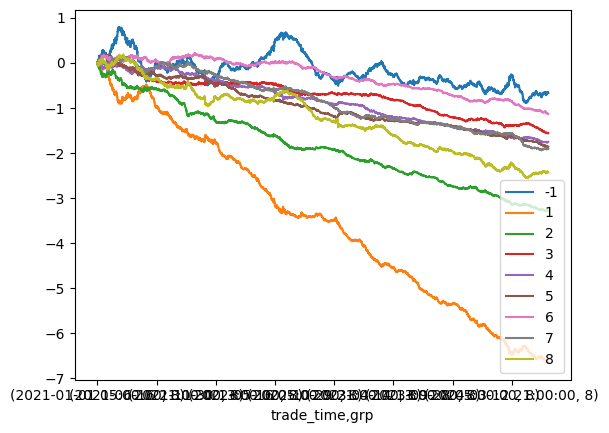

In [75]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
df = sess.runFile('factors/factor1.dos')
df = df[df['trade_time'] >= '20210101']
# df['factor_value'] = df['factor_value']
sess.close()
ic = backtest(df)
# draw(ic)
stats = cal_stats(ic)
print(stats)
rev = backtest_rev(df, 4)
# print(rev)
draw_rev(rev)

In [56]:
rev

,trade_time,grp,cumret,cnt,cumfee,af_rev
0,2021-01-01 09:00:00,1,-0.006783,10,0.000200,-0.006983
1,2021-01-01 17:00:00,1,0.000905,10,0.000360,0.000545
2,2021-01-02 01:00:00,1,-0.008602,10,0.000560,-0.009162
3,2021-01-02 09:00:00,1,-0.026659,10,0.000720,-0.027379
4,2021-01-02 17:00:00,1,-0.029485,10,0.000880,-0.030365
...,...,...,...,...,...,...
34276,2024-06-22 09:00:00,-1,5.521548,0,1.260619,4.260929
34277,2024-06-22 17:00:00,-1,5.519846,0,1.260926,4.258919
34278,2024-06-23 01:00:00,-1,5.514079,0,1.261370,4.252708
34279,2024-06-23 09:00:00,-1,5.521746,0,1.261678,4.260067


{'pic': 0.008457472553571009, 'pic_t': 10.467530236574808, 'sic': 0.025207296212543546, 'sic_t': 31.622835421391553}


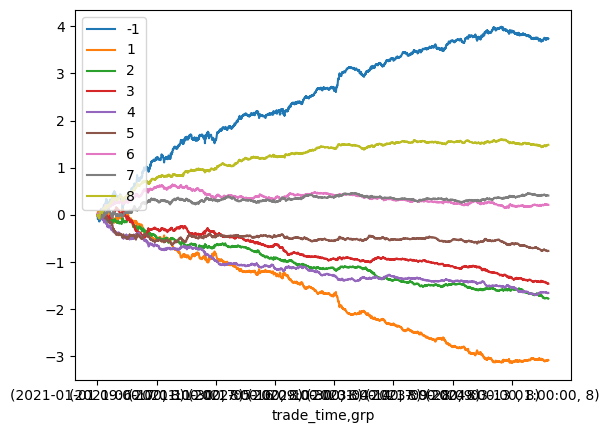

In [38]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
df1 = sess.runFile('factors/factor6.dos')
df1 = df1[df1['trade_time'] >= '20210101']
df2 = sess.runFile('factors/factor4.dos')
df2 = df2[df2['trade_time'] >= '20210101']
df = pd.merge(df1, df2, how='outer', on=['trade_time', 'instrument'])
df['factor_value'] = df['factor_value_y'] + df['factor_value_x']
sess.close()
df = df[['trade_time', 'instrument', 'factor_value']]
ic = backtest(df)
# draw(ic)
stats = cal_stats(ic)
print(stats)
rev = backtest_rev(df, 8)
# print(rev)
draw_rev(rev)

In [48]:
test = pd.merge(df1, df2, how='outer', on=['trade_time', 'instrument'])
test

,trade_time,instrument,factor_value_x,factor_value_y
0,2021-01-01 00:00:00,1INCHUSDT,-0.415740,-2.217297
1,2021-01-01 00:00:00,AAVEUSDT,-0.392314,-1.513679
2,2021-01-01 00:00:00,ADAUSDT,-0.620765,0.094274
3,2021-01-01 00:00:00,ALGOUSDT,-0.300347,-0.817225
4,2021-01-01 00:00:00,ALPHAUSDT,-0.308085,0.379912
...,...,...,...,...
4884973,2024-06-23 17:00:00,ZETAUSDT,-0.094016,-0.174339
4884974,2024-06-23 17:00:00,ZILUSDT,6.119812,0.295883
4884975,2024-06-23 17:00:00,ZKUSDT,-0.867563,-1.887528
4884976,2024-06-23 17:00:00,ZROUSDT,-0.975008,0.489495


In [49]:
df1.set_index(['trade_time', 'instrument']).corrwith(df2.set_index(['trade_time', 'instrument']))

factor_value    0.173633
dtype: float64

In [21]:
print(stats)

{'pic': 0.04070090076343706, 'pic_t': 37.56478537231641, 'sic': 0.045367801093052655, 'sic_t': 51.57772888631318}


In [36]:
rev

,trade_time,grp,cumret,cnt,cumfee,af_rev
0,2021-01-01 09:00:00,1,0.012781,10,0.000080,0.012701
1,2021-01-01 17:00:00,1,0.023887,10,0.000160,0.023727
2,2021-01-02 01:00:00,1,0.030624,10,0.000160,0.030464
3,2021-01-02 09:00:00,1,0.037724,10,0.000320,0.037404
4,2021-01-02 17:00:00,1,0.052238,10,0.000360,0.051878
...,...,...,...,...,...,...
34276,2024-06-22 09:00:00,-1,47.128781,0,0.692335,46.436445
34277,2024-06-22 17:00:00,-1,47.147030,0,0.692485,46.454545
34278,2024-06-23 01:00:00,-1,47.170601,0,0.692705,46.477896
34279,2024-06-23 09:00:00,-1,47.200004,0,0.692901,46.507103


In [363]:
rev

,trade_time,grp,cumret,cnt,cumfee,af_rev
0,2021-01-01 12:00:00,1,0.014688,10,0.000120,0.014568
1,2021-01-01 23:00:00,1,0.025657,10,0.000120,0.025537
2,2021-01-02 10:00:00,1,0.028359,10,0.000280,0.028079
3,2021-01-02 21:00:00,1,0.042905,10,0.000400,0.042505
4,2021-01-03 08:00:00,1,0.064786,10,0.000560,0.064226
...,...,...,...,...,...,...
24511,2024-05-31 17:00:00,-1,3.297372,0,0.667417,2.629955
24512,2024-06-01 04:00:00,-1,3.279956,0,0.667686,2.612270
24513,2024-06-01 15:00:00,-1,3.273437,0,0.667846,2.605591
24514,2024-06-02 02:00:00,-1,3.267825,0,0.668068,2.599758


grp
-1    AxesSubplot(0.125,0.11;0.775x0.77)
 1    AxesSubplot(0.125,0.11;0.775x0.77)
 2    AxesSubplot(0.125,0.11;0.775x0.77)
Name: af_rev, dtype: object

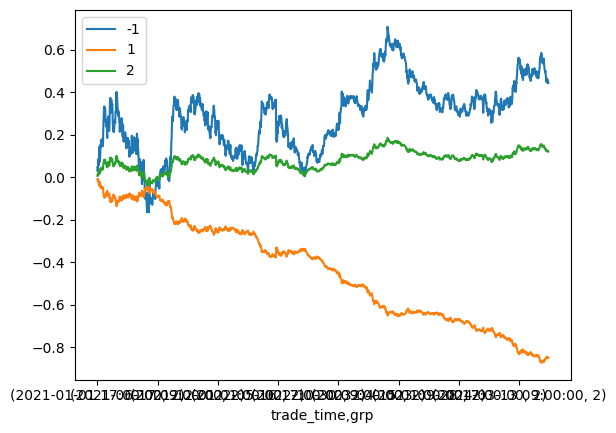

In [194]:
rev.set_index(['trade_time', 'grp']).groupby(level=1)['af_rev'].plot(legend=True)

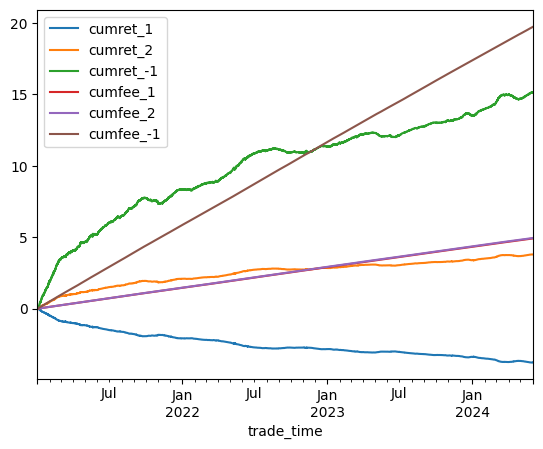

In [144]:
for grp in rev['grp'].unique():
    tmp = rev[rev['grp']==grp].set_index('trade_time')['cumret']
    tmp.name = f'cumret_{grp}'
    tmp.plot(legend=True)
for grp in rev['grp'].unique():
    tmp = rev[rev['grp']==grp].set_index('trade_time')['cumfee']
    tmp.name = f'cumfee_{grp}'
    tmp.plot(legend=True)
# rev.set_index(['trade_time', 'grp']).groupby(level=1)['cumret'].plot(legend=True)
# rev.set_index(['trade_time', 'grp']).groupby(level=1)['cumfee'].plot(legend=True)
# rev.set_index(['trade_time', 'grp']).groupby(level=1)['cnt'].plot(legend=True)
# rev.columns
# rev.set_index(['trade_time', 'grp']).groupby(level=1)['cumret'].plot(legend=True)
# rev

In [156]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')

ic_map = {}
for i in range(1, 102):
# for i in range(101, 102):
    try:
        df = sess.run(f'''
            factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
            factor = table(factor.rowNames() as trade_time, factor)
            factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
            factor.rename!(`trade_time`instrument`factor_value)
            factor = select trade_time, instrument, factor_value from factor where factor_value is not null
            select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
        ''')
        # print(df)
        ic = backtest(df)
        stats = cal_stats(ic)
        # print(stats)
        if abs(stats['pic']) > 0.01:
            print(i, stats)
            ic_map[i] = stats
        # draw(result)
    except:
        print("skip ", i)
sess.close()

1 {'pic': -0.01107390141525562, 'pic_t': -15.51010280299113, 'sic': -0.026169398176016847, 'sic_t': -35.45384095809065}
Server response: 'backtest(factor) => backtest: combine = get_factor_return(factor) => get_factor_return: throw "factor null ratio > 30%, check!", null_ratio[null_ratio["ratio"] > 0.3] => trade_time              ratio             ----------------------- ----------------- 2021.01.01T01:00:00.000 0.74025974025974  2021.01.01T02:00:00.000 0.688311688311688 2021.01.01T03:00:00.000 0.714285714285714 2021.01.01T04:00:00.000 0.74025974025974  2021.01.01T05:00:00.000 0.74025974025974  2021.01.01T06:00:00.000 0.766233766233766 2021.01.01T07:00:00.000 0.766233766233766 2021.01.01T08:00:00.000 0.714285714285714 2021.01.01T09:00:00.000 0.701298701298701 2021.01.01T10:00:00.000 0.701298701298701 2021.01.01T11:00:00.000 0.701298701298701 2021.01.01T12:00:00.000 0.675324675324675 2021.01.01T13:00:00.000 0.675324675324675 2021.01.01T14:00:00.000 0.701298701298701 2021.01.01T15:00:00.

In [168]:
for idx, value in ic_map.items():
    print(idx, value['pic'])

1 -0.01107390141525562
5 0.01027447906645336
7 0.016465315018955692
17 0.022646570813459947
19 0.014015957945833043
25 0.01711924695710663
33 0.02552217400895376
35 -0.030467255751983
37 0.010852438745430454
38 0.02789183328107705
44 0.010842397253721985
54 0.011117691178816875
60 0.010668740995300468
62 0.01045262743580425
101 -0.01990218479432065


In [159]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')

i = 56
df = sess.run(f'''
    factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
    factor = table(factor.rowNames() as trade_time, factor)
    factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
    factor.rename!(`trade_time`instrument`factor_value)
    factor = select trade_time, instrument, zscore(factor_value) as factor_value from factor where factor_value is not null
    select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
''')
# df['factor_value'] = -df['factor_value']
sess.close()
# df = df[df['trade_time'] >= '20200201']
# print(df)
ic = backtest(df)
draw(ic)

RuntimeError: Server response: 'factor = calAlpha56(instruments, 2020.12.01T00:00:00.000, 2024.01.01T00:00:00.000) => calAlpha56: input = prepare56(data, startTime, endTime) => prepare56: t = select securityid,tradetime,close,cap from data where tradetime between startTime : endTime => Unrecognized column name cap' script: '
    factor = calAlpha56(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
    factor = table(factor.rowNames() as trade_time, factor)
    factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
    factor.rename!(`trade_time`instrument`factor_value)
    factor = select trade_time, instrument, zscore(factor_value) as factor_value from factor where factor_value is not null
    select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
'

In [33]:
lucky = ''
with open('ic.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'pic' in line:
            # print(line)
            idx = line.split('{')[0].strip()
            ic = line.split('{')[1].split(',')[0].split(':')[1].strip()
            if abs(float(ic)) > 0.3:
                lucky += f'{idx},{ic}\n'
lucky = lucky.strip()
print(lucky)

33,-0.3714130552740507
38,-0.3071903609530031
54,-0.3900010142603009
101,0.33290886290211014


In [222]:
import dolphindb as ddb
import pandas as pd


sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
# lucky = '''19,1.7492571361873892
# 38,2.2345266919595885'''
tot = None
for idx, value in ic_map.items():
    # parts = line.split(',')
    i = idx
    weight = value['pic']
    df: pd.DataFrame = sess.run(f'''
        factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
        factor = table(factor.rowNames() as trade_time, factor)
        factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
        factor.rename!(`trade_time`instrument`factor_value)
        factor = select timestamp(trade_time) as trade_time, instrument, zscore(factor_value) as factor_value from factor where factor_value is not null
        // factor = select trade_time, instrument, factor_value / max(abs(factor_value)) as factor_value from factor context by trade_time
        select * from factor where trade_time >= 2021.01.01 order by trade_time, instrument
    ''')
    df['factor_value'] = df['factor_value'] * weight
    # result = backtest(df, 2)
    # sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
    # print(sharpe)
    if tot is not None:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = pd.merge(tot, df, how='left', on=['trade_time', 'instrument'])
    else:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = df
# else:
#     df = sess.runFile('factors/factor1.dos')
#     df = df[df['trade_time'] >= '20210101']
#     df['factor_value'] = df['factor_value'] * -0.3966229795014131
#     df = df.rename(columns={'factor_value': 'factor_value_1'})
#     tot = pd.merge(tot, df, how='left', on=['trade_time', 'instrument'])
print(tot)
# print(df)
# result = backtest(df, 2)
# sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
# print(sharpe)
# draw(result)

sess.close()

        trade_time     instrument  factor_value_1  factor_value_5  \
0       2021-01-01   1000BONKUSDT        0.009697             NaN   
1       2021-01-01  1000FLOKIUSDT        0.009697             NaN   
2       2021-01-01   1000LUNCUSDT        0.009697             NaN   
3       2021-01-01   1000PEPEUSDT        0.009697             NaN   
4       2021-01-01   1000RATSUSDT        0.009697             NaN   
...            ...            ...             ...             ...   
6622807 2024-01-01        YGGUSDT        0.005934        0.001182   
6622808 2024-01-01        ZECUSDT       -0.000247        0.010763   
6622809 2024-01-01        ZENUSDT       -0.007772        0.007595   
6622810 2024-01-01        ZILUSDT       -0.007772       -0.002087   
6622811 2024-01-01        ZRXUSDT       -0.007772       -0.004705   

         factor_value_7  factor_value_17  factor_value_19  factor_value_25  \
0              0.000179              NaN              NaN              NaN   
1              

In [223]:
# df = tot[tot.isna()]
df = tot.fillna(0)
df
# tot[tot['factor_value_19'].isna()]

,trade_time,instrument,factor_value_1,factor_value_5,factor_value_7,factor_value_17,factor_value_19,factor_value_25,factor_value_33,factor_value_35,factor_value_37,factor_value_38,factor_value_44,factor_value_54,factor_value_60,factor_value_62,factor_value_101
0,2021-01-01,1000BONKUSDT,0.009697,0.000000,0.000179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011338,0.000000
1,2021-01-01,1000FLOKIUSDT,0.009697,0.000000,0.000179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011338,0.000000
2,2021-01-01,1000LUNCUSDT,0.009697,0.000000,0.000179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011338,0.000000
3,2021-01-01,1000PEPEUSDT,0.009697,0.000000,0.000179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011338,0.000000
4,2021-01-01,1000RATSUSDT,0.009697,0.000000,0.000179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011338,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622807,2024-01-01,YGGUSDT,0.005934,0.001182,0.030689,0.007345,0.015275,-0.005634,-0.032481,-0.006196,-0.002133,0.010858,0.006692,-0.010817,-0.000911,0.009636,-0.026374
6622808,2024-01-01,ZECUSDT,-0.000247,0.010763,0.000179,-0.010466,0.010286,-0.017861,0.026462,0.018102,-0.007943,0.018988,0.013646,-0.000964,0.008702,0.009636,-0.008008
6622809,2024-01-01,ZENUSDT,-0.007772,0.007595,0.012198,-0.047930,0.011117,-0.020796,-0.029206,-0.036121,-0.008381,-0.019495,-0.010872,-0.006362,0.001265,0.009636,-0.025574
6622810,2024-01-01,ZILUSDT,-0.007772,-0.002087,0.000179,-0.002418,-0.014320,0.010752,-0.008103,-0.041974,0.002690,-0.030194,-0.009410,-0.006459,0.001152,0.009636,-0.004517


{'pic': 0.030349179602076677, 'pic_t': 29.75542297932736, 'sic': 0.04346699259840796, 'sic_t': 50.06466888696533}
               trade_time  grp     cumret  cnt     cumfee    af_rev
0     2021-01-01 02:00:00    1   0.000972   40   0.000180  0.000792
1     2021-01-01 03:00:00    1   0.000002   39   0.000385 -0.000384
2     2021-01-01 04:00:00    1   0.001891   39   0.000559  0.001332
3     2021-01-01 05:00:00    1   0.003156   39   0.000713  0.002442
4     2021-01-01 06:00:00    1   0.000629   39   0.000898 -0.000269
...                   ...  ...        ...  ...        ...       ...
78832 2023-12-31 20:00:00   -1  11.142348    0  18.802062 -7.659714
78833 2023-12-31 21:00:00   -1  11.142304    0  18.802793 -7.660489
78834 2023-12-31 22:00:00   -1  11.142076    0  18.803490 -7.661414
78835 2023-12-31 23:00:00   -1  11.136068    0  18.804160 -7.668093
78836 2024-01-01 00:00:00   -1  11.136847    0  18.805760 -7.668914

[78837 rows x 6 columns]


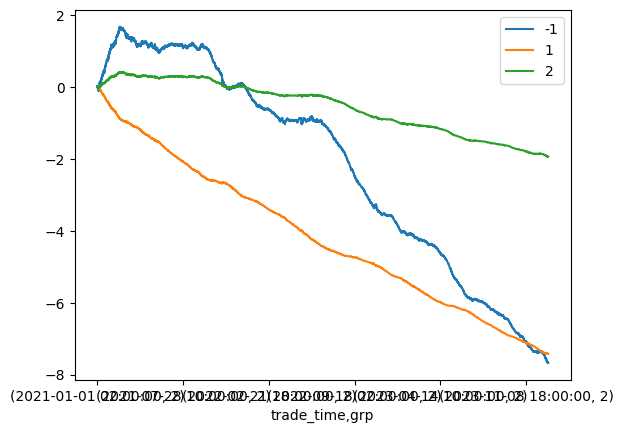

In [266]:
baseline = df.copy()
baseline['factor_value'] = baseline.iloc[:, 2:].mean(axis=1)
baseline = baseline[['trade_time', 'instrument', 'factor_value']]
# print(baseline)
baseline = baseline[baseline['trade_time'] > '20210101']
ic = backtest(baseline)
# sharpe = cal_sharpe(ic[ic['grp']==-1]['cumret'])
# print(sharpe)
# draw(ic)
print(cal_stats(ic))
rev = backtest_rev(baseline)
print(rev)
draw_rev(rev)

               trade_time  grp     cumret  cnt     cumfee    af_rev
0     2021-01-01 02:00:00    1   0.001093   39   0.000144  0.000949
1     2021-01-01 03:00:00    1   0.000916   39   0.000318  0.000598
2     2021-01-01 04:00:00    1   0.003014   39   0.000462  0.002553
3     2021-01-01 05:00:00    1   0.003953   39   0.000615  0.003337
4     2021-01-01 06:00:00    1   0.000474   39   0.000821 -0.000347
...                   ...  ...        ...  ...        ...       ...
89887 2024-06-02 09:00:00   -1  15.134276    0  19.751958 -4.617681
89888 2024-06-02 10:00:00   -1  15.129412    0  19.752546 -4.623135
89889 2024-06-02 11:00:00   -1  15.133555    0  19.753110 -4.619556
89890 2024-06-02 12:00:00   -1  15.132546    0  19.753797 -4.621251
89891 2024-06-02 13:00:00   -1  15.116482    0  19.755397 -4.638915

[89892 rows x 6 columns]


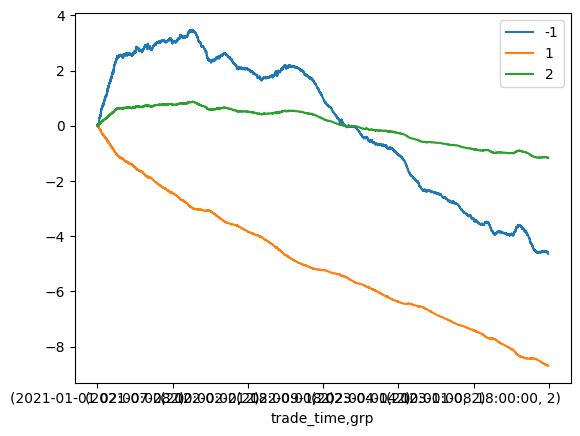

In [212]:
draw_rev(rev)

In [261]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sql = '''
def get_coin_listinfo() {
    return select instrument, min(trade_time) as list_time from loadTable("dfs://crypto_db", "k_hour") group by instrument
}

def get_label(factor) {
    min_time = min(factor['trade_time'])
    max_time = max(factor['trade_time'])
    vwap = select trade_time, instrument, amount / volume as vwap from loadTable("dfs://crypto_db", "k_hour") where trade_time >= min_time and trade_time <= temporalAdd(max_time, 2, `d) and trade_time >= 2020.02.01
    listinfo = get_coin_listinfo()
    vwap = lj(vwap, listinfo, `instrument)
    // 剔除上市未满7天
    vwap = select trade_time, instrument, vwap from vwap where trade_time >= temporalAdd(list_time, 7, `d)
    crypto_return = select trade_time, instrument, ffill(move(log(ratios(vwap)), -2)) as ret from vwap context by instrument
    // 每小时的未来vwap return
    crypto_return = select * from crypto_return where trade_time > min_time and trade_time <= max_time and ret is not null order by trade_time, instrument
    crypto_return = select trade_time, instrument, zscore(ret - mean(ret)) as label from crypto_return context by trade_time
    return crypto_return
}

get_label(df)
'''
sess.run("df = table(1000:0,`trade_time`instrument, [TIMESTAMP,SYMBOL])")
sess.run("tableInsert{df}",df[['trade_time', 'instrument']])
df_return = sess.run(sql)
sess.close()
factor_with_label = pd.merge(df, df_return, how='left', on=['trade_time', 'instrument'])
factor_with_label = factor_with_label.dropna()

In [262]:
factor_with_label
# 参数遍历

,trade_time,instrument,factor_value_1,factor_value_5,factor_value_7,factor_value_17,factor_value_19,factor_value_25,factor_value_33,factor_value_35,factor_value_37,factor_value_38,factor_value_44,factor_value_54,factor_value_60,factor_value_62,factor_value_101,label
261,2021-01-01 01:00:00,AAVEUSDT,-0.015163,0.002475,0.000179,0.010916,-0.015778,-0.019940,-0.017283,0.009886,-0.021675,-0.034746,-0.007268,-0.010258,0.003043,0.009636,-0.036045,0.216243
264,2021-01-01 01:00:00,ADAUSDT,-0.017582,0.000991,0.039010,-0.004018,0.017075,-0.006988,-0.024084,-0.027289,0.013500,-0.007649,-0.009888,-0.002070,-0.028070,-0.011338,-0.021361,-0.325893
267,2021-01-01 01:00:00,ALGOUSDT,-0.017582,0.000416,0.000179,0.006931,0.014720,0.007488,0.026923,0.014795,0.007012,0.011903,-0.001070,0.002479,0.012759,0.009636,-0.013349,-0.689816
269,2021-01-01 01:00:00,ALPHAUSDT,0.009697,0.003157,0.032538,0.012127,0.011658,0.026535,0.041659,0.005778,0.005987,0.024772,0.010117,0.011859,0.020304,0.009636,0.008874,1.533479
283,2021-01-01 01:00:00,ATOMUSDT,-0.017582,0.003937,-0.039576,0.008310,-0.017426,-0.016131,-0.018417,-0.058662,-0.014845,-0.040970,-0.015266,-0.002757,-0.008053,0.009636,-0.020086,0.325517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622807,2024-01-01 00:00:00,YGGUSDT,0.005934,0.001182,0.030689,0.007345,0.015275,-0.005634,-0.032481,-0.006196,-0.002133,0.010858,0.006692,-0.010817,-0.000911,0.009636,-0.026374,0.753099
6622808,2024-01-01 00:00:00,ZECUSDT,-0.000247,0.010763,0.000179,-0.010466,0.010286,-0.017861,0.026462,0.018102,-0.007943,0.018988,0.013646,-0.000964,0.008702,0.009636,-0.008008,-0.286968
6622809,2024-01-01 00:00:00,ZENUSDT,-0.007772,0.007595,0.012198,-0.047930,0.011117,-0.020796,-0.029206,-0.036121,-0.008381,-0.019495,-0.010872,-0.006362,0.001265,0.009636,-0.025574,-0.525757
6622810,2024-01-01 00:00:00,ZILUSDT,-0.007772,-0.002087,0.000179,-0.002418,-0.014320,0.010752,-0.008103,-0.041974,0.002690,-0.030194,-0.009410,-0.006459,0.001152,0.009636,-0.004517,-0.506588


In [252]:
factor_with_label[factor_with_label.columns[2:]].corr()

,factor_value_1,factor_value_5,factor_value_7,factor_value_17,factor_value_19,factor_value_25,factor_value_33,factor_value_35,factor_value_37,factor_value_38,factor_value_44,factor_value_54,factor_value_60,factor_value_62,factor_value_101,label
factor_value_1,1.000000,0.152046,0.155024,0.220039,0.167701,0.137606,0.140855,0.176779,0.113863,0.286018,0.084651,0.054378,0.038561,0.040403,0.107562,0.134690
factor_value_5,0.152046,1.000000,0.162904,0.203194,0.235069,0.345466,0.239406,0.229412,0.282043,0.336475,0.084460,0.233830,-0.062491,0.032631,0.244114,0.017105
factor_value_7,0.155024,0.162904,1.000000,0.261664,0.527936,0.104730,0.163537,0.549137,0.100076,0.314279,0.269070,0.125238,-0.039054,0.080479,0.272117,0.018703
factor_value_17,0.220039,0.203194,0.261664,1.000000,0.263146,0.374727,0.410762,0.445224,0.274430,0.607453,0.175635,0.181138,0.017944,0.143973,0.335213,0.030858
factor_value_19,0.167701,0.235069,0.527936,0.263146,1.000000,0.094898,0.145642,0.421565,0.095186,0.364716,0.186426,0.144670,-0.056132,0.055700,0.230639,0.019112
factor_value_25,0.137606,0.345466,0.104730,0.374727,0.094898,1.000000,0.534590,0.266221,0.657144,0.459400,0.049201,0.266822,-0.008311,0.105728,0.505418,0.018966
factor_value_33,0.140855,0.239406,0.163537,0.410762,0.145642,0.534590,1.000000,0.395470,0.369795,0.726730,0.071627,0.408890,0.327511,0.161733,0.520962,0.031659
factor_value_35,0.176779,0.229412,0.549137,0.445224,0.421565,0.266221,0.395470,1.000000,0.197923,0.448011,0.209439,0.329843,0.047026,0.166308,0.507860,0.032329
factor_value_37,0.113863,0.282043,0.100076,0.274430,0.095186,0.657144,0.369795,0.197923,1.000000,0.335637,0.048164,0.210669,-0.060386,0.075259,0.385174,0.013242
factor_value_38,0.286018,0.336475,0.314279,0.607453,0.364716,0.459400,0.726730,0.448011,0.335637,1.000000,0.183759,0.323720,0.153953,0.157031,0.431291,0.033651


In [172]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# 使用MSE作为划分标准训练随机森林模型
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=8, verbose=2)
factors = factor_with_label.columns[2:-1]
factor_with_return_train = factor_with_label[factor_with_label['trade_time']<'20230101']
X_train, X_test, y_train, y_test = train_test_split(factor_with_return_train[factors], factor_with_return_train['label'], test_size=0.2, shuffle=False)
rf.fit(X_train, y_train)

# # 使用MSE评估模型
y_pred = rf.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print('Mean squared error: ', mse)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100

building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100



[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.2min


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [173]:
y_pred = rf.predict(X_test)
# print(y_pred)
# print(y_test)
# mse = mean_squared_error(y_test, y_pred)
# print('Mean squared error: ', mse)
factors

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


Index(['factor_value_1', 'factor_value_5', 'factor_value_7', 'factor_value_17',
       'factor_value_19', 'factor_value_25', 'factor_value_33',
       'factor_value_35', 'factor_value_37', 'factor_value_38',
       'factor_value_44', 'factor_value_54', 'factor_value_60',
       'factor_value_62', 'factor_value_101'],
      dtype='object')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
/var/folders/h6/c2kcrdsn239c6mbd3hhp4ss80000gn/T/ipykernel_46933/1793965370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_factor['factor_value'] = y_pred


{'pic': 0.024290845293653582, 'pic_t': 12.185577134916493, 'sic': 0.03699395595440321, 'sic_t': 26.298249201653}


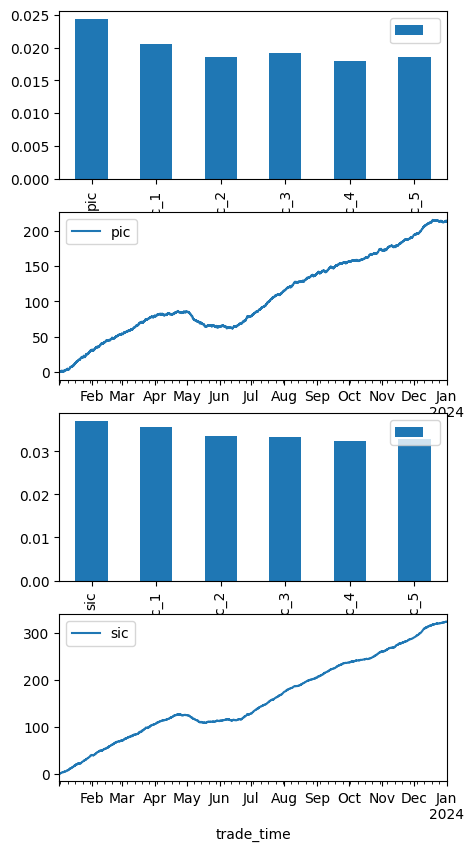

In [174]:
factor_with_return_test = factor_with_label[factor_with_label['trade_time']>='20230101']
y_pred = rf.predict(factor_with_return_test[factors])
combo_factor = factor_with_return_test[['trade_time', 'instrument']]
combo_factor['factor_value'] = y_pred
combo_factor

ic = backtest(combo_factor)
draw(ic)
print(cal_stats(ic))
rev = backtest_rev(combo_factor)

In [175]:
rev

,trade_time,grp,cumret,cnt,cumfee,af_rev
0,2023-01-01 01:00:00,1,-0.000190,86,0.000126,-0.000316
1,2023-01-01 02:00:00,1,-0.000350,96,0.000321,-0.000672
2,2023-01-01 03:00:00,1,-0.000598,78,0.000455,-0.001053
3,2023-01-01 04:00:00,1,-0.000635,102,0.000639,-0.001274
4,2023-01-01 05:00:00,1,-0.000703,84,0.000782,-0.001485
...,...,...,...,...,...,...
26275,2023-12-31 20:00:00,-1,2.051014,0,6.820570,-4.769556
26276,2023-12-31 21:00:00,-1,2.054242,0,6.821366,-4.767123
26277,2023-12-31 22:00:00,-1,2.055022,0,6.822201,-4.767179
26278,2023-12-31 23:00:00,-1,2.052349,0,6.823074,-4.770725


In [231]:
ic_map

{1: {'pic': -0.01107390141525562,
  'pic_t': -15.51010280299113,
  'sic': -0.026169398176016847,
  'sic_t': -35.45384095809065},
 5: {'pic': 0.01027447906645336,
  'pic_t': 12.719008273149798,
  'sic': 0.01809077391894515,
  'sic_t': 22.23379484741239},
 7: {'pic': 0.016465315018955692,
  'pic_t': 15.524930040659978,
  'sic': 0.02082814090540613,
  'sic_t': 27.79543870495842},
 17: {'pic': 0.022646570813459947,
  'pic_t': 25.772072753592393,
  'sic': 0.028722597797057735,
  'sic_t': 38.36936257010817},
 19: {'pic': 0.014015957945833043,
  'pic_t': 14.42340695045779,
  'sic': 0.028399576263204607,
  'sic_t': 29.147499120587234},
 25: {'pic': 0.01711924695710663,
  'pic_t': 22.69128858998605,
  'sic': 0.024094204788933704,
  'sic_t': 31.49553413512357},
 33: {'pic': 0.02552217400895376,
  'pic_t': 28.123613808174714,
  'sic': 0.041668576940264296,
  'sic_t': 45.297930795773},
 35: {'pic': -0.030467255751983,
  'pic_t': -26.99869651305524,
  'sic': -0.03836606052994333,
  'sic_t': -45.586

In [134]:
factor_with_label

,trade_time,instrument,factor_value_19,label
0,2021-01-01,1INCHUSDT,1.202553,0.336138
1,2021-01-01,AAVEUSDT,-1.988298,0.410967
2,2021-01-01,ADAUSDT,2.152387,0.200281
3,2021-01-01,ALGOUSDT,1.840723,0.392544
4,2021-01-01,ALPHAUSDT,1.529059,0.808269
...,...,...,...,...
3801170,2024-01-01,YGGUSDT,1.940017,-0.015374
3801171,2024-01-01,ZECUSDT,1.292307,-0.364049
3801172,2024-01-01,ZENUSDT,1.393368,-0.336163
3801173,2024-01-01,ZILUSDT,-1.822218,-0.155200


In [263]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 假设我们有一个DataFrame，名为df，其中包含8个特征X1到X8
#我们还有一个目标变量名为y，它可能是你想预测的复合因子。
# X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
# y = df['y']

# 我们将数据集划分为训练集和测试集
factors = factor_with_label.columns[2:-1]
factor_with_return_train = factor_with_label[factor_with_label['trade_time']<'20230101']
X_train, X_test, y_train, y_test = train_test_split(factor_with_return_train[factors], factor_with_return_train['label'], test_size=0.2, shuffle=True)


# 将DataFrame转换为DMatrix对象，这是XGBoost的内置数据结构，可以提升性能
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 定义参数
params = {'objective': 'reg:squarederror', 
          'booster': 'gbtree',  
          'eta': 0.03,  
          'max_depth': 5, 
          'subsample': 0.8,  
          'colsample_bytree': 0.6,  
          'silent': 1,  
          'seed': 10}  
num_round = 50  # the number of training iterations

# 训练模型
bst = xgb.train(params, dtrain, num_round)

# 利用测试集进行预测
y_pred = bst.predict(dtest)

# 输出预测结果
# plt.plot(range(len(y_pred)), abs(y_pred - y_test))
# plt.show()
print(y_test.abs().mean())
print(mean_squared_error(y_test, y_pred))

# xgb.plot_importance(bst)

/opt/homebrew/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:33:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.6430265829339695
0.9997724089245591


/var/folders/h6/c2kcrdsn239c6mbd3hhp4ss80000gn/T/ipykernel_46933/2926572551.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_factor['factor_value'] = y_pred


{'pic': 0.05575659384155695, 'pic_t': 34.78705769191176, 'sic': 0.06481692346377195, 'sic_t': 56.824317006926705}


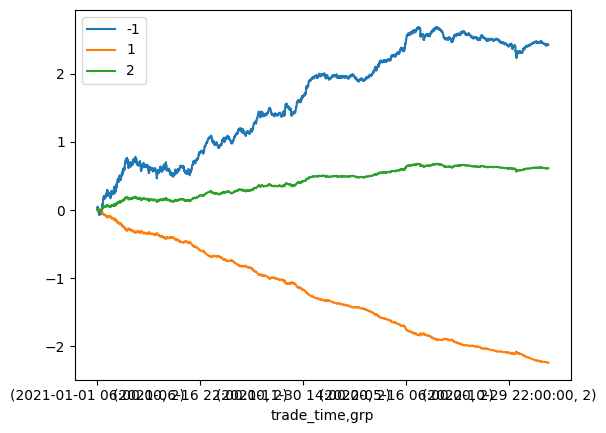

In [264]:
factor_with_return_test = factor_with_label[factor_with_label['trade_time']<'20230101']
x_test = xgb.DMatrix(factor_with_return_test[factors], label=None)
y_pred = bst.predict(x_test)
combo_factor = factor_with_return_test[['trade_time', 'instrument']]
combo_factor['factor_value'] = y_pred
# combo_factor

ic = backtest(combo_factor)
# draw(ic)
print(cal_stats(ic))
rev = backtest_rev(combo_factor)
draw_rev(rev)

/var/folders/h6/c2kcrdsn239c6mbd3hhp4ss80000gn/T/ipykernel_46933/3371717241.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_factor['factor_value'] = y_pred


{'pic': 0.032691905733990764, 'pic_t': 14.872729009500665, 'sic': 0.042853621347142025, 'sic_t': 30.01032949367155}


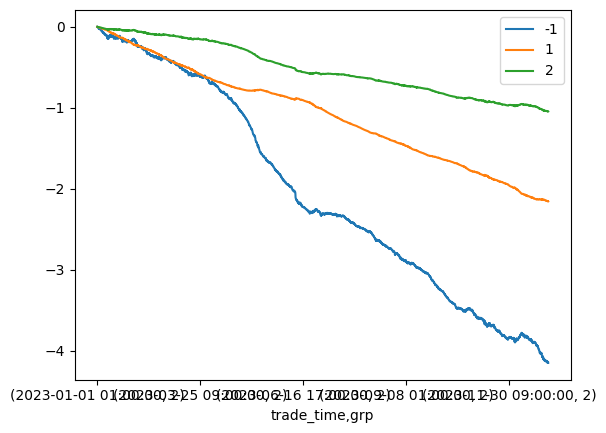

In [265]:
factor_with_return_test = factor_with_label[factor_with_label['trade_time']>='20230101']
x_test = xgb.DMatrix(factor_with_return_test[factors], label=None)
y_pred = bst.predict(x_test)
combo_factor = factor_with_return_test[['trade_time', 'instrument']]
combo_factor['factor_value'] = y_pred
combo_factor

ic = backtest(combo_factor)
# sharpe = cal_sharpe(ic[ic['grp']==-1]['cumret'])
# print(sharpe)
# draw(ic)
print(cal_stats(ic))
rev = backtest_rev(combo_factor)
draw_rev(rev)

In [9]:
import numpy as np
factor_with_label['trade_time'].unique()
# np.array(factor_with_label[factor_with_label['trade_time']<'20230101'].iloc[:, 2:])

array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ...,
       '2023-12-31T22:00:00.000000000', '2023-12-31T23:00:00.000000000',
       '2024-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

timestep = 24  # 时间步长，就是利用多少时间窗口
batch_size = 1024 * 4  # 批次大小
input_dim = len(factor_with_label.columns) - 3  # 每个步长对应的特征数量

# 形成训练数据，例如12345变成12-3，23-4，34-5
def split_data(data, timestep, input_dim):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep + 1):
        dataX.append(data[index: index + timestep, :-1])
        dataY.append(data[index + timestep - 1][-1])

    dataX = np.array(dataX)
    dataY = np.array(dataY)
    # 获取训练集大小
    train_size = int(np.round(0.6 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, input_dim)
    y_train = dataY[: train_size]

    x_test = dataX[train_size:, :].reshape(-1, timestep, input_dim)
    y_test = dataY[train_size:]

    return [x_train, y_train, x_test, y_test]

# 3.获取训练数据   x_train: 1700,1,4
data = np.array(factor_with_label.iloc[:, 2:])
x_train, y_train, x_test, y_test = split_data(data, timestep, input_dim)

# 4.将数据转为tensor
device = torch.device("cpu")
x_train_tensor = torch.from_numpy(x_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32).to(device)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32).to(device)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size,
                                           True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size,
                                          False)

In [35]:
hidden_dim = 4  # 隐层大小
output_dim = 1  # 由于是回归任务，最终输出层大小为1
num_layers = 1  # LSTM的层数


class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM层数
        # input_dim为特征维度，就是每个时间点对应的特征数量，这里为14
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, h_n = self.gru(x)
        
        # print(output.shape) #torch.Size([16, 1, 64]) batch_size,timestep,hidden_dim
        # print(h_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        # print(c_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        batch_size, timestep, hidden_dim = output.shape

        # 将output变成 batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_dim)
        output = self.bn(output)
        output = self.fc(output)  # 形状为batch_size * timestep, output
        output = output.reshape(timestep, batch_size, -1)
        return self.sigmoid(output[-1])  # 返回最后一个时间片的输出

model = GRU(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络

# loss_function = nn.MSELoss()  # 定义损失函数
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.mse_loss = nn.MSELoss()   # 计算每个样本的 MSE

    def forward(self, pred, actual):
        # mse = self.mse_loss(pred, actual)  # 计算每个样本的平均 MSE
        combined = torch.cat((pred, actual), dim=1)
        corr = combined.reshape(combined.shape[::-1]).corrcoef()
        corr_good = -(corr.sum(dim=1)[-1] - 1)
        corr_bad = (corr[:corr.shape[0]-1, :corr.shape[0]-1].sum(dim=1)[-1] - 1)
        # print(corr_good, corr_bad)
        loss = corr_good + 0.005 * corr_bad
        # loss = mse + 0.005 * corr_bad
        # loss = corr_good
        return loss  # 最后求平均
    
loss_function = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 定义优化器
epochs = 5
best_loss = 1e10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for idx, data in enumerate(train_bar):
        x_train, y_train = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred: torch.Tensor = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 running_loss / (idx + 1))
    if running_loss / len(train_bar) < best_loss * 0.99:
        best_loss = running_loss / len(train_bar)
    else:
        break

train epoch[5/5] loss:-0.779: 100%|██████████| 557/557 [00:25<00:00, 21.80it/s]


[9.9819094e-01 9.9247879e-01 9.6766889e-01 ... 2.2881777e-05 8.7530025e-06
 3.4483483e-06]
0.7027806610784313


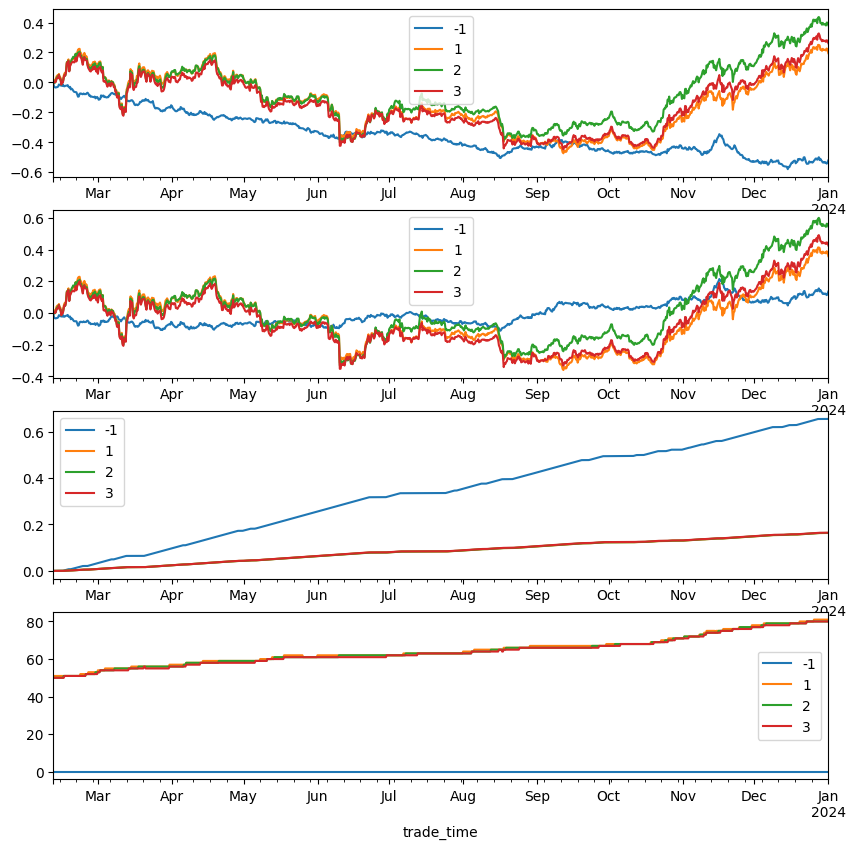

In [34]:
# model.train()
# test_bar = tqdm(test_loader)  # 形成进度条
# y_test_pred_all = np.array([])
# for idx, data in enumerate(test_bar):
#     x_test, y_test = data  # 解包迭代器中的X和Y
#     optimizer.zero_grad()
#     y_test_pred: torch.Tensor = model(x_test)
#     # print(y_test_pred.shape)
#     # total_length += y_test_pred.shape[0]
#     y_test_pred = y_test_pred.mean(dim=1)
#     print(y_test_pred.shape)
#     y_test_pred_all = np.concatenate((y_test_pred_all, y_test_pred.detach().numpy().flatten()))
#     loss = loss_function(y_test_pred, y_test.reshape(-1, 1))
#     loss.backward()
#     optimizer.step()

model.eval()
y_test_pred = model(x_test_tensor)
y_test_pred = y_test_pred.mean(dim=1)
y_test_pred = y_test_pred.detach().numpy().flatten()
y_test_pred_all = y_test_pred
print(y_test_pred_all)
combo_factor = factor_with_label[['trade_time', 'instrument']].iloc[-len(y_test_pred_all):, :]
combo_factor['factor_value'] = y_test_pred_all
# combo_factor

ic = backtest(combo_factor, 3)
sharpe = cal_sharpe(ic[ic['grp']==-1]['cumret'])
print(sharpe)
draw(ic)

In [141]:
y_test[-1]

-0.02092380576391628

In [143]:
factor_with_label.iloc[-1]

trade_time         2024-01-01 00:00:00
instrument                     ZRXUSDT
factor_value_2               -0.383473
factor_value_6               -0.507317
factor_value_19              -1.330693
factor_value_30              -0.198099
factor_value_37              -1.447098
factor_value_38              -3.603493
factor_value_54              -1.420135
factor_value_60               0.464949
ret                           0.010867
Name: 3801190, dtype: object

In [15]:
y_test_pred.detach().numpy()

array([[-0.0067648 ],
       [-0.02335713],
       [-0.02679934],
       ...,
       [-0.00543373],
       [-0.01420163],
       [-0.02503951]], dtype=float32)